#  ElectroCardioGram (ECG)

The ECG waveform reflects the electrical activity of the heart. It is widely used as a routine cardiac diagnostic tool. The ECG signal is a repetitive waveform that comprises several waves distinguished each other by frequencies and amplitudes. These waves originate from different parts of the heart and are denoted by letters P, QRS, T and U

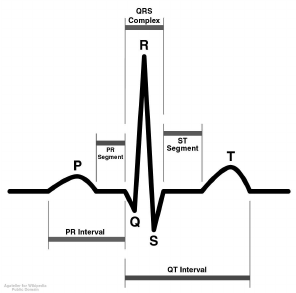

In [1]:
from IPython.display import Image
Image("C:/Users/Prajwal/Desktop/froot img/Schematic-representation-of-normal-ECG.png")

In conventional methods of ECG diagnosis, physician tries to find whether the ECG signal is different from normal sinus rhythm in terms of the morphology of each component, time intervals and heart rate. Considering the large numbers of critical patients and the need for accurate interpretation of their cardiac status and the limitations of human to observe the fine details in ECG waveform led to the introduction of automated arrhythmia monitoring systems to assist cardiologists in detecting the signs of arrhythmia at early stages which can save patients lives.


__DATABASE__:- MIT-BIH arrhythmia database available at Physionet website. ECG signals are sampled at the rate of 360 samples/sec.


### Loading the ECG signal:

ECG signal is loaded in python using WFDB library. Its loads the ECG of all the channels along with list of information regarding the ECG


In [2]:
cd Desktop/ecg_m

C:\Users\Prajwal\Desktop\ecg_m


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as ss
import wfdb
from ecg import ecg_utils as eu
from ecg import ecg_module as em

In [4]:
data_dir = 'C:\\Users\\Prajwal\\Desktop\\pune_froot\\mitdb\\'
sample = '111'
sig, fields = wfdb.rdsamp(data_dir+sample)

In [5]:
print(fields)

{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['47 F 937 167 x1', 'Digoxin, Lasix', 'There is first degree AV block.  There are short bursts of both baseline', 'shifts and muscle noise, but in general, the quality is excellent.']}


In [6]:
data_signals = dict([(x, y) for x,y in zip(fields['sig_name'], sig.T)])
fs = fields['fs']

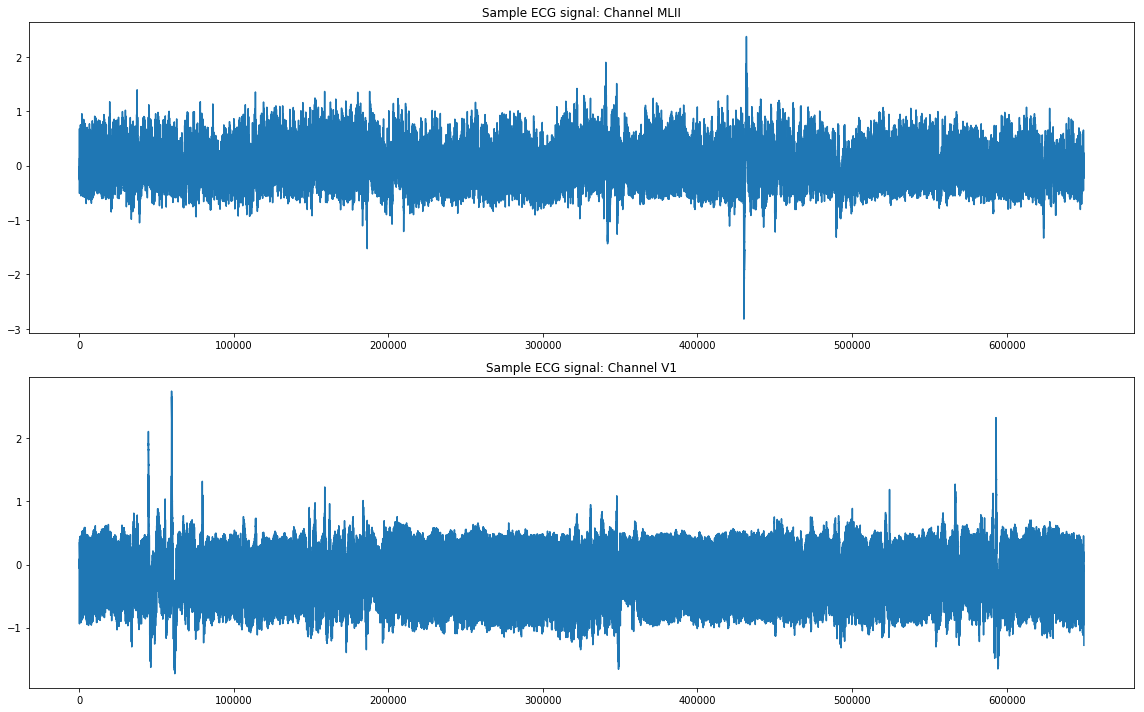

In [7]:
fig, ax = plt.subplots(len(data_signals), figsize = [16, 10])
for i in range(len(data_signals)):
    key = fields['sig_name'][i]
    ax[i].plot(data_signals[key])
    ax[i].set_title('Sample ECG signal: Channel '+key)
    
plt.tight_layout()
plt.show()

### Preprocessing of an ECG signal

To clean the ECG signal, we perform a series of pre-processing techniques to the raw signal. We perform (1) __high-pass filtering (2) low-pass filtering and, (3) baseline correction__. Locating R peaks is also included in the pre-processing of the ECG signal.


In [8]:
sample_signal = data_signals['MLII']
processed_ECG = em.Signal(sample_signal, fs)

In [9]:
# Dataframe containing processed ECG data and R peak locations
ecg_df = processed_ECG.df
ecg_df.head()

,ecg,_time_sec,processed,r_peak
0,-0.035,0.000000,0.043154,0
1,-0.035,0.002778,0.043533,0
2,-0.035,0.005556,0.043914,0
3,-0.035,0.008333,0.044295,0
4,-0.035,0.011111,0.044675,0


In [10]:
# Array containing R peak indices
rpeaks = processed_ECG.rpeaks

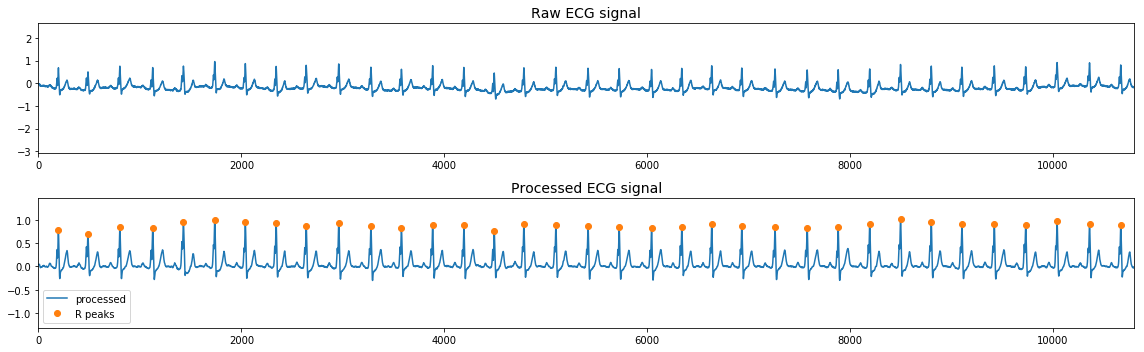

In [11]:
fig, axes = plt.subplots(2, figsize = [16, 5])
ecg_df.ecg.plot(ax=axes[0])
axes[0].set_title('Raw ECG signal', fontsize = 14)
axes[0].set_xlim([0, fs*30])
ecg_df.processed.plot(ax=axes[1])
axes[1].plot(rpeaks, ecg_df.processed.ix[rpeaks], 'o', label = 'R peaks')
axes[1].set_title('Processed ECG signal', fontsize = 14)
axes[1].set_xlim([0, fs*30])
plt.legend()
plt.tight_layout()
plt.show()

## Calculation of some physiological parameters


### Heart rate


In [12]:
processed_ECG.get_heartrate(unit='permin')
print('Estimated heart rate: {} beats/min'.format(round(processed_ECG.heartrate, 2)))
processed_ECG.get_heartrate(unit='persec')
print('Estimated heart rate: {} beats/sec'.format(round(processed_ECG.heartrate, 2)))

Estimated heart rate: 70.4 beats/min
Estimated heart rate: 1.17 beats/sec



### Heart rate variability


In [13]:
processed_ECG.get_heartratevar(unit='s')
print('Estimated heart rate: {} s'.format(round(processed_ECG.heartratevar, 2)))
processed_ECG.get_heartratevar(unit='ms')
print('Estimated heart rate: {} ms'.format(round(processed_ECG.heartratevar, 2)))

Estimated heart rate: 0.06 s
Estimated heart rate: 56.07 ms


## Divide the raw data into windows

Analyzing data with small windows help in understanding it microscopically and extract relevant features from them

In [14]:
# Set size of segment
window_dur = 30 # in seconds
window_size = fs*window_dur

In [15]:
# Tag each datapoint with segment_id
processed_ECG.add_segment_id(window_size, trunc_end=True)
processed_ECG.df.head()

Last segment is shorter than window size was removed.


,ecg,_time_sec,processed,r_peak,segment_id
0,-0.035,0.000000,0.043154,0,0
1,-0.035,0.002778,0.043533,0,0
2,-0.035,0.005556,0.043914,0,0
3,-0.035,0.008333,0.044295,0,0
4,-0.035,0.011111,0.044675,0,0


In [16]:
# Dataframe with containing compiled segments
print('Total number of ECG segments: {}'.format(len(processed_ECG.segments_df)))
processed_ECG.segments_df.head()

Total number of ECG segments: 60


,processed
segment_id,
0,"[0.0431542807298778, 0.043533468154272774, 0.0..."
1,"[-0.012197591283678408, -0.011834925096499013,..."
2,"[-0.02026868285639849, -0.01713636382838178, -..."
3,"[-0.024899429966283318, -0.023764025435858302,..."
4,"[0.04715268988485712, 0.05533250338531324, 0.0..."


In [17]:
final_feats=processed_ECG.get_segment_feats(get_beats=True)
final_feats.head()

Computing features...
Done!


,processed,r_peaks,rr_int,hr_permin,hrv_ms,HRV_ind_15,rpeak_beat_pair,beats,f_stddev,f_kurtosis,...,f_powspec8,f_powspec9,f_rpeakcount,f_nhr,f_hrv,f_rtor,f_sumbe,f_pca,f_mbe,f_maxminbeat
segment_id,,,,,,,,,,,,,,,,,,,,,
0,"[0.0431542807298778, 0.043533468154272774, 0.0...","[196, 488, 802, 1126, 1429, 1738, 2039, 2343, ...","[292, 314, 324, 303, 309, 301, 304, 296, 321, ...",70.129870,25.529967,"[[12.724350313830994, 9.329003324594918, 0.0, ...","[(196, [-0.03701076358564945, -0.0343226406503...","[[-0.03701076358564945, -0.03432264065031107, ...",0.176992,6.717201,...,0.429004,0.142806,35,1.166667,25.529967,855.555556,9921.598156,3.693593,8.239660,1.107190
1,"[-0.012197591283678408, -0.011834925096499013,...","[169, 474, 803, 1134, 1452, 1772, 2087, 2395, ...","[305, 329, 331, 318, 320, 315, 308, 316, 333, ...",68.690373,27.533360,"[[12.478731906728344, 10.065693310357803, 0.0,...","[(169, [-0.04586321891202125, -0.0473202494827...","[[-0.04586321891202125, -0.047320249482735624,...",0.168641,6.907774,...,0.455620,0.181803,34,1.166667,27.533360,873.484848,8648.896225,3.720710,7.914927,1.088090
2,"[-0.02026868285639849, -0.01713636382838178, -...","[52, 352, 684, 1014, 1341, 1652, 1966, 2275, 2...","[300, 332, 330, 327, 311, 314, 309, 306, 320, ...",68.041237,28.154773,"[[12.098553632562862, 10.292870436286558, 0.0,...","[(52, [-0.023043337388398574, -0.0208525360725...","[[-0.023043337388398574, -0.02085253607257892,...",0.169172,6.147878,...,0.363625,0.152835,34,1.133333,28.154773,881.818182,7436.954567,2.529240,6.777221,1.015336
3,"[-0.024899429966283318, -0.023764025435858302,...","[38, 342, 670, 1003, 1325, 1628, 1935, 2247, 2...","[304, 328, 333, 322, 303, 307, 312, 304, 325, ...",68.616276,28.897210,"[[12.180461254141255, 10.55944044593246, 0.0, ...","[(38, [-0.017667633577630446, -0.0113647335083...","[[-0.017667633577630446, -0.011364733508354471...",0.174410,7.663869,...,0.327139,0.141862,35,1.133333,28.897210,874.428105,6139.859611,1.230676,5.435861,0.840072
4,"[0.04715268988485712, 0.05533250338531324, 0.0...","[242, 558, 887, 1210, 1515, 1831, 2142, 2449, ...","[316, 329, 323, 305, 316, 311, 307, 318, 333, ...",68.690373,29.013675,"[[12.546164752624604, 10.606869557894159, 0.0,...","[(242, [-0.04217331567528475, -0.0392005907360...","[[-0.04217331567528475, -0.0392005907360911, -...",0.173908,5.664081,...,0.454258,0.150561,34,1.133333,29.013675,873.484848,7711.908057,1.861317,7.090058,0.990554


In [18]:
processed_ECG.beats_df.head()

,beat_rpeak,beat_mag
segment_id,,
0,"[196, 488, 802, 1126, 1429, 1738, 2039, 2343, ...","[[-0.03701076358564945, -0.03432264065031107, ..."
1,"[169, 474, 803, 1134, 1452, 1772, 2087, 2395, ...","[[-0.04586321891202125, -0.047320249482735624,..."
2,"[52, 352, 684, 1014, 1341, 1652, 1966, 2275, 2...","[[-0.023043337388398574, -0.02085253607257892,..."
3,"[38, 342, 670, 1003, 1325, 1628, 1935, 2247, 2...","[[-0.017667633577630446, -0.011364733508354471..."
4,"[242, 558, 887, 1210, 1515, 1831, 2142, 2449, ...","[[-0.04217331567528475, -0.0392005907360911, -..."
